In [2]:
#!/bin/env python
from __future__ import division
import sys
import healpy as hp
import numpy as np
import matplotlib.pyplot as mp
from qubic import *
from pysimulators import FitsArray
import time
import os


# External library needed (not part of qubic yet)
import SpectroImLib as si

%matplotlib inline
rc('figure',figsize=(15,10))
rc('font',size=20)

/Users/hamilton/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


## TD Selection

In [3]:
TD = True
path = QubicCalibration().path
if(TD):
	print('Technological Demonstrator')
	os.system('\cp '+path+'/TD_CalQubic_HornArray_v4.fits '+path+'/CalQubic_HornArray_v5.fits')
	os.system('\cp '+path+'/TD_CalQubic_DetArray_v3.fits '+path+'/CalQubic_DetArray_v4.fits')
else:
	print('First Instrument')
	os.system('rm -f '+path+'/CalQubic_HornArray_v5.fits')
	os.system('rm -f '+path+'/CalQubic_DetArray_v4.fits')

Technological Demonstrator


## Actually use TD++ (with full horn array but only 1/4 focal plane)

In [4]:
os.system('rm -f '+path+'/CalQubic_HornArray_v5.fits')

0

## Instrument

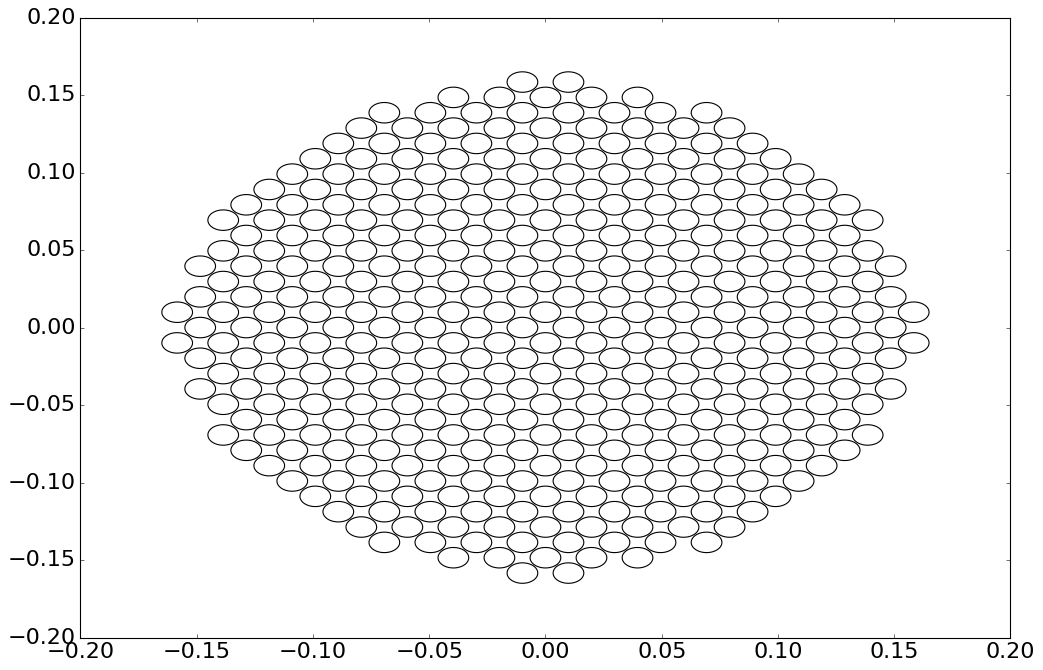

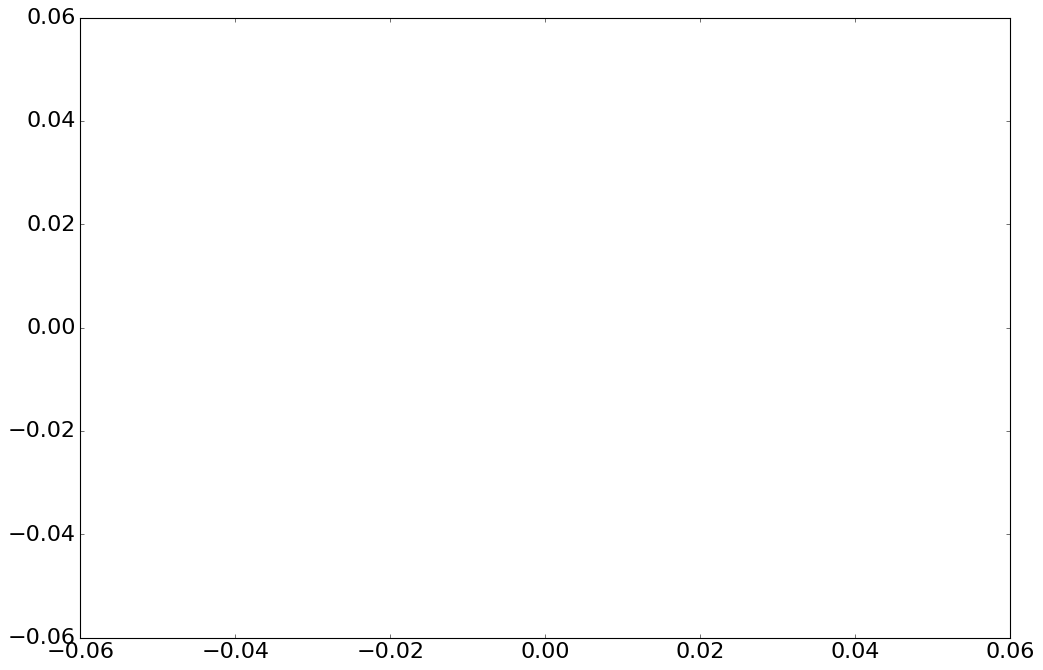

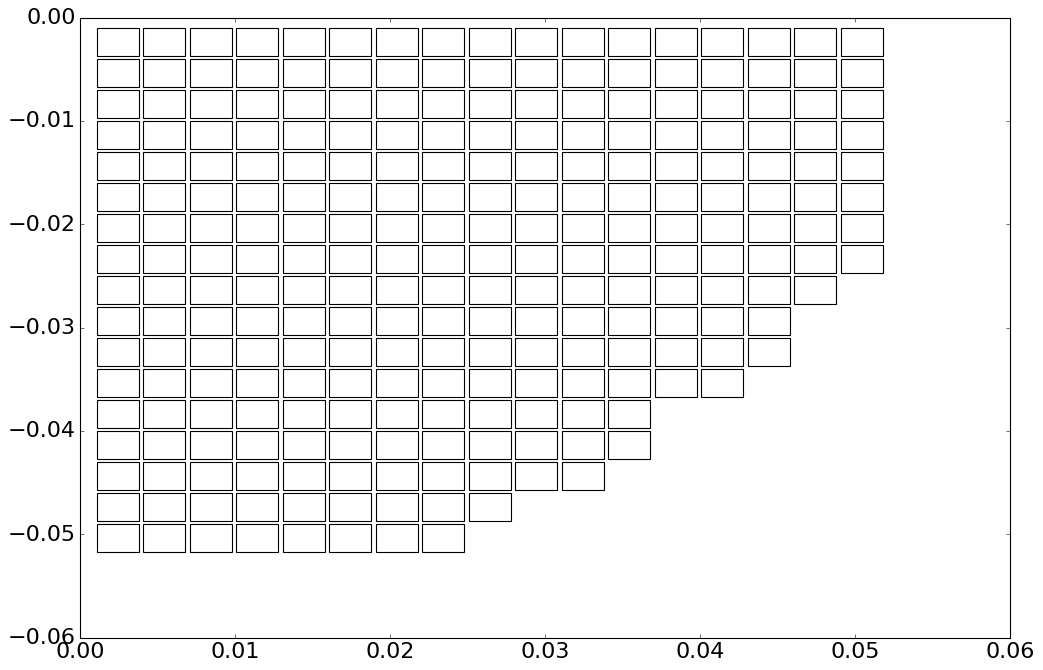

In [5]:
inst = QubicInstrument()
inst.horn.plot()
inst.detector.plot()

## Configuration for 1 month data

In [6]:
### Sky 
nside = 128
center = 0., -57.
center_gal = equ2gal(center[0], center[1])
dust_coeff = 1.39e-2
seed=None

### Detectors (for now using random pointing)
band = 150
relative_bandwidth = 0.25
sz_ptg = 10.
nb_ptg = 1000
effective_duration = 30./365
ripples = False   
noiseless = False


### Mapmaking
tol = 1e-3

### Number of sub-bands to build the TOD
nf_sub_build = 10
nf_sub_rec = 3

parameters = {'nside':nside, 'center':center, 'dust_coeff': dust_coeff, 
				'band':band, 'relative_bandwidth':relative_bandwidth,
				'sz_ptg':sz_ptg, 'nb_ptg':nb_ptg, 'effective_duration':effective_duration, 
				'tol': tol, 'ripples':ripples,
				'nf_sub_build':nf_sub_build, 
				'nf_sub_rec': nf_sub_rec, 'noiseless':noiseless, 'seed':seed}


for k in parameters.keys(): print(k, parameters[k])

('nside', 128)
('nb_ptg', 1000)
('band', 150)
('seed', None)
('relative_bandwidth', 0.25)
('nf_sub_rec', 3)
('dust_coeff', 0.0139)
('nf_sub_build', 10)
('center', (0.0, -57.0))
('sz_ptg', 10.0)
('ripples', False)
('noiseless', False)
('tol', 0.001)
('effective_duration', 0.0821917808219178)


## Input Sky Simulation, TOD fabircation and Map-Making

In [7]:
print('Creating input sky')
x0 = si.create_input_sky(parameters)

print('Creating pointing')
p = si.create_random_pointings(parameters['center'], parameters['nb_ptg'], parameters['sz_ptg'])

print('Creating TOD')
TOD = si.create_TOD(parameters, p, x0)

print('Doing Mapmaking on {} sub-map(s)'.format(nf_sub_rec))
maps_recon, cov, nus, nus_edge, maps_convolved = si.reconstruct_maps(TOD, parameters, p, x0=x0)
if int(parameters['nf_sub_rec'])==1: maps_recon=np.reshape(maps_recon, np.shape(maps_convolved))
cov = np.sum(cov, axis=0)
maxcov = np.max(cov)
unseen = cov < maxcov*0.1
diffmap = maps_convolved - maps_recon
maps_convolved[:,unseen,:] = hp.UNSEEN
maps_recon[:,unseen,:] = hp.UNSEEN
diffmap[:,unseen,:] = hp.UNSEEN
therms = np.std(diffmap[:,~unseen,:], axis = 1)

Creating input sky
Creating pointing
Creating TOD
Info jch-mac.local: Allocating (248000,12) elements = 45.41015625 MiB in FSRRotation3dMatrix.__init__.
Info jch-mac.local: Allocating (248000,12) elements = 45.41015625 MiB in FSRRotation3dMatrix.__init__.
Info jch-mac.local: Allocating (248000,12) elements = 45.41015625 MiB in FSRRotation3dMatrix.__init__.
Info jch-mac.local: Allocating (248000,13) elements = 49.1943359375 MiB in FSRRotation3dMatrix.__init__.
Info jch-mac.local: Allocating (248000,13) elements = 49.1943359375 MiB in FSRRotation3dMatrix.__init__.
Info jch-mac.local: Allocating (248000,14) elements = 52.978515625 MiB in FSRRotation3dMatrix.__init__.
Info jch-mac.local: Allocating (248000,15) elements = 56.7626953125 MiB in FSRRotation3dMatrix.__init__.
Info jch-mac.local: Allocating (248000,16) elements = 60.546875 MiB in FSRRotation3dMatrix.__init__.
Info jch-mac.local: Allocating (248000,17) elements = 64.3310546875 MiB in FSRRotation3dMatrix.__init__.
Info jch-mac.loc

## Visualization of results
With 1 month of data we can see the temperature, but not the polarization.

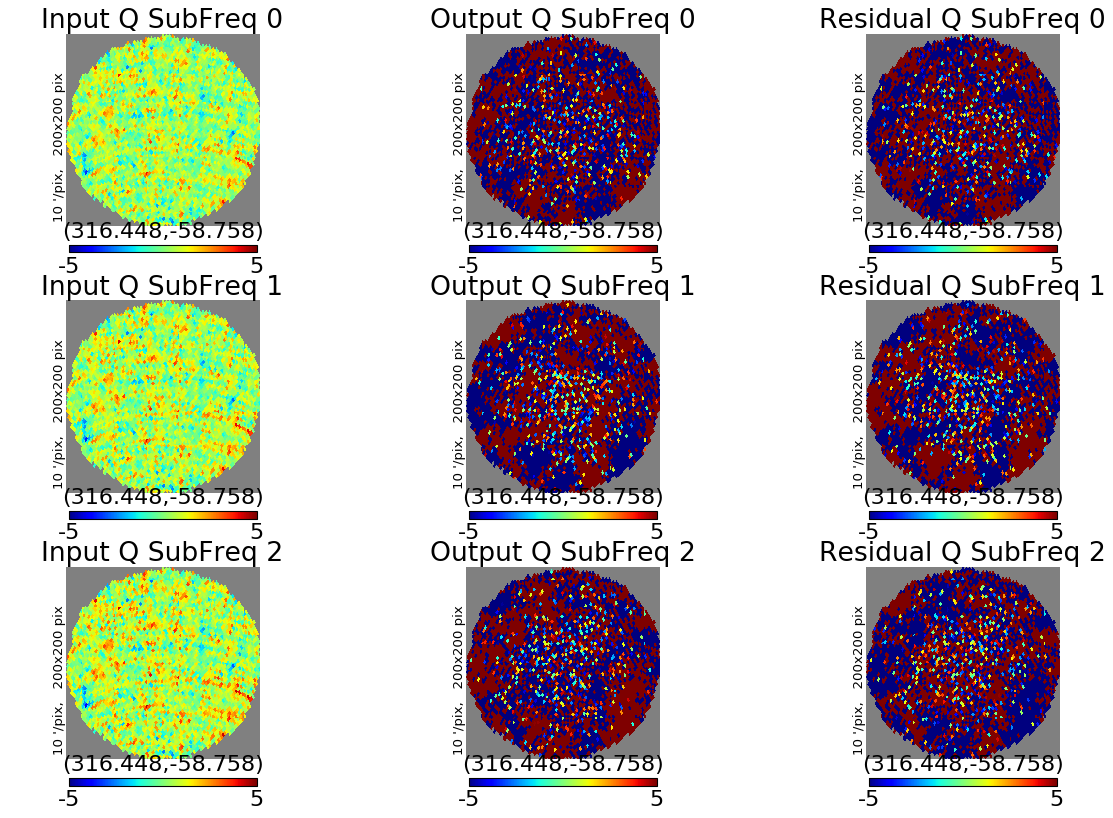

In [11]:
stokes = ['I', 'Q', 'U']
istokes=1
if istokes==0: 
    xr=200
else:
    xr=5
for i in xrange(parameters['nf_sub_rec']):
    hp.gnomview(maps_convolved[i,:,istokes], rot=center_gal, reso=10, 
        sub=(parameters['nf_sub_rec'],3,3*i+1), min=-xr, max=xr, 
        title='Input '+stokes[istokes]+' SubFreq {}'.format(i))
    hp.gnomview(maps_recon[i,:,istokes], rot=center_gal, reso=10, 
        sub=(parameters['nf_sub_rec'],3,3*i+2), min=-xr, max=xr, 
        title='Output '+stokes[istokes]+' SubFreq {}'.format(i))
    hp.gnomview(diffmap[i,:,istokes], rot=center_gal, reso=10, 
        sub=(parameters['nf_sub_rec'],3,3*i+3), min=-xr, max=xr, 
        title='Residual '+stokes[istokes]+' SubFreq {}'.format(i))